# TILT - Teemo Induced Loss of Tranquility
A research project to study main factors in inducing tilt.

ONLY LOOKS AT THE PERSON STATS THEMSELVES


# Imports

In [1]:
# from collections import defaultdict
# TODO: maybe not have all those skleans and just import sklearn or use as to shorten them  
from datetime import datetime
from pathlib2 import Path
from riotwatcher import LolWatcher, ApiError
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier



from tenacity import retry, wait_random_exponential, retry_if_exception_type


# import arrow
# import csv
import itertools
import datetime
# import time
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline

# Functions

In [2]:
def touch(path):
    """
    Creates a file and directories in the path if it doesnt exists.

    Args:
        path (str): File path.
    Returns:
        None
    """
    basedir = os.path.dirname(path)
    if not os.path.exists(basedir):
        os.makedirs(basedir)
    with open(path, mode="a"):
        pass
        

In [3]:
def drop_keys(dictionary, drop_keys):
    """
    Remove unwanted keys from a dictionary. 
    
    Args:
        dict (dict): The dictionary to remove keys from.
        drop_keys (set): Keys to be removed.   
    Returns:
        final_dict (dict): Dictionary without the drop_keys.
    """
    final_dict = {key: dictionary[key] for key in dictionary if key not in drop_keys}

    return final_dict

In [4]:
def overwrite(file_path):
    """
    Overwrite a file if it exists or offers to use a new file path

    Args:
        file_path (str): File path to a file
    Returns:
        None
    """
    while Path(file_path).exists():
        answer = input("""Enter "yes" to overwrite file, or enter new filepath""")
        if answer.upper() in ["Y", "YES"]:
            os.remove(file_path)
        else:
            file_path = answer
            touch(file_path)

In [5]:
def api_key(api_key_loc):
    """
    Read in the development API key from a file and checks if it is viable.
    
    Args:
        credentials (str): Name of json file containing the credentials.
    Returns:
        api_key (str): The API key.
    """

    # Keep requestion for a correct key or until canceled
    while True:
        with open(api_key_loc, "r") as credentials:
            creds = json.load(credentials)
            api_key = creds["dev_api_key"]
            lol_watcher = LolWatcher(creds["dev_api_key"])
            try:
                # Validate API key by using it to check server status
                lol_watcher.data_dragon.versions_all()
                # Break if key is functional
                break
            except ApiError as error:
                # If the current API key does not work input new one
                if error.response.status_code == 403:
                    new_api_key = input("API key is incorrect, enter correct key here.")
                    creds["dev_api_key"] = new_api_key
                    # Replace the old API key
                    with open(api_key_loc, "w") as json_data:
                        json.dump(creds, json_data)
    return api_key

In [6]:
def adj_patch_time(reg, patch_nr="now"):
    # TODO: add option to fill in time epoch instead of only patch nrs
    """
    Read the patch number and return the time adjusted for timezones.  
    
    Args:
        reg (str): Official registered Riot server that hosts league of legends.
        patch_nr (str): League of legends update patch number. 
            Defaults to "now" which is the current time.
    Returns:
        adj_time (long): Time in ms following the Coordinated Universal Time (UTC) format.
    """

    # Read patch data
    patch_loc = proj_dir / "data" / "patches.json"
    with open(patch_loc, "r") as in_file:
        patch_data = json.load(in_file)
    
    # Set the base utc time
    if patch_nr == "now":
        patch_time = int(datetime.utcnow().timestamp())
    else:
        for patch in patch_data["patches"]:
            if patch["name"] == patch_nr:
                patch_time = patch["start"]
    # Check if patch number is valid
    assert patch_time, f"Patch number: {patch_nr} is unknown"

    # Set the time shift
    try:
        reg_shifts = patch_data["shifts"][reg.upper()]
    except KeyError:
        # Check if region provided is valid
        raise KeyError(f"Region: {reg} is unknown")
    
    # Calculate time adjusted for the time shift of the region
    adj_time = patch_time + reg_shifts
    return adj_time

In [7]:
def trans_reg(reg_abbrv):
    """
    Translate a league of legends region into a region readable by riot watcher.
    
    Args:
        reg_abbrv (str): Abbreviation of a official registered Riot servers that
            hosts league of legends (e.g. euw1).
    Returns:
        rw_region (str): Riot Watcher region the reg_abbrv server falls under.
    """
    # Look up in the list what the riot watcher region is for the given region abbreviation
    regions_metadata = {"br1": "americas",
                        "eun1": "europe",
                        "euw1": "europe",
                        "jp1": "asia",
                        "kr": "asia",
                        "la1": "americas",
                        "la2": "americas",
                        "na1": "americas",
                        "oc1": "americas",
                        "tr1": "europe",
                        "ru": "europe"
                        }

    for reg, rw_reg in regions_metadata.items():
        if reg_abbrv.lower() == reg:
            rw_region = rw_reg
    
    return rw_region

In [8]:
@retry(wait=wait_random_exponential(multiplier=1, max=30),
       retry=retry_if_exception_type(ApiError))
def get_matches(reg, pid, s_time, e_time):
    """
    Retrieve match IDs from a summoner within a given timeframe.

    Args:
        reg (str): Abbreviation of a official registered Riot servers that
            hosts league of legends (e.g. euw1).
        pid (str): An Encrypted globally unique identifyer for a summoner.
        s_time (long): Start of a timeframe in (milli)seconds following
            the Coordinated Universal Time (UTC) format.
        e_time (long): end of a timeframe in (milli)seconds following
            the Coordinated Universal Time (UTC) format.
    Returns:
        matches (list): League of legends match IDs in chronological order
            starting with the most recent match.
    """

    # Retrieve all match ID's between two time points
    rw_reg = trans_reg(reg)
    matches = lol_watcher.match.matchlist_by_puuid(region=rw_reg,
                                                   puuid=pid,
                                                   start_time=s_time,
                                                   count=100,
                                                   queue=420,
                                                   end_time=e_time)
    
    # Geather more match IDs in case matches exceeds the standard limit of 100
    while len(matches) % 100 == 0 and len(matches) != 0:
        # Geather match details of earliest match
        match_deets = lol_watcher.match.by_id(rw_reg, matches[-1])
        # Start time of earliest match
        early_g_start = int(str(match_deets["info"]["gameCreation"])[:10])
        # Select 100 matches previous to early_g_start  
        match_add = lol_watcher.match.matchlist_by_puuid(region=rw_reg,
                                                         puuid=pid,
                                                         start_time=s_time,
                                                         count=100,
                                                         queue=420,
                                                         end_time=early_g_start)
        if len(match_add) == 0:
            break
        else:
            matches.extend(match_add)

    return matches

In [9]:
@retry(wait=wait_random_exponential(multiplier=1, max=30),
       retry=retry_if_exception_type(ApiError))
def geather_data(puuid, matches):
    """
    Geather summoner data from a match and chronology data of the match.
    
    Args:
        puuid (str): An Encrypted globally unique identifyer for a summoner.
        matches (list): League of legends match IDs in chronological order
                        starting with the most recent match.  
    Returns:
        df_matches_data (df): Data geathered from matches of a summoner.
    """
    
    comp_data = []
    # Geather match details
    for match_id in matches:
        reg = match_id.split("_")[0].lower()
        match_deets = lol_watcher.match.by_id(trans_reg(reg), match_id)

        # Collect time data
        time_info = {"gameCreation", "gameStartTimestamp"}
        time_data = dict((key, match_deets["info"][key]) for key in time_info)

        # Collect summoner data
        for game_info in match_deets["info"]["participants"]:
            # Mark the protagonist
            prota_stat = {"prota": False}
            if game_info["puuid"] == puuid:
                prota_stat = {"prota": True}
            # Combine the data data
            match_data = {"reg":reg, "match_id": match_id} | game_info | prota_stat | time_data
            comp_data.append(match_data)
    
    # Store all data in a dataframe
    df_matches = pd.DataFrame.from_dict(comp_data) 

    # Add rest time between previous and next match as a base to filter on
    df_matches["game_end"] = df_matches.loc[:,["gameStartTimestamp", "timePlayed"]].sum(axis=1)
    df_matches["game_end_prev"] = df_matches["game_end"].shift(-10, fill_value=np.nan)
    df_matches["game_make_next"] = df_matches["gameCreation"].shift(10, fill_value=np.nan)
    df_matches["time_since_last"] = df_matches["gameCreation"] - df_matches["game_end_prev"]
    df_matches["time_till_next"] = df_matches["game_make_next"] - df_matches["game_end"]

    return df_matches

In [10]:
def filt_matches(matches_data, max_rest, min_streak):
    """
    Filter matches based on rest time in between matches and number of matches played in a row.  
    
    Args:
        matches_data (df): Data geathered from matches of a summoner.
        max_rest (int): Rest time in between matches in miliseconds e.g. 3600000 = 1 hour.
        min_streak (int): Minimum games played in a row with less then max_rest between.
    Returns:
        df_match_streak (df): Matches left over after filtered based on minimum subsequent matches within
            the maximum rest time in between the matches.
        df_match_nostreak (df): The matches filtered out based on minimum subsequent matches within
            the maximum rest time in between the matches.
    """
    
    # Filter for matches based on rest time below the max_rest time
    
    # Find games that were played in a streak by grouping based on matches played subsequently
    # Copy index to know where a empty line was inserted
    matches_data["idx"] = matches_data.index
    df_prota = matches_data.loc[matches_data["prota"] == True]
    # Add empty lines between groups to split them up
    indices = np.where(np.logical_or(df_prota["time_till_next"] >= max_rest, 
                       np.isnan(df_prota["game_make_next"])))[0] * 10
    rows_ = dict.fromkeys(df_prota.columns.tolist(), np.nan)
    # Add empty lines
    matches_data = pd.DataFrame(np.insert(matches_data.values, [x for x in indices],
                                           values=list(rows_.values()),
                                           axis=0),columns=rows_.keys())

    # Temporarily store streak_id to know how big the groups are
    game_streak = matches_data["idx"].diff().ne(1).cumsum()
    matches_data["streak_id"] = matches_data.groupby(game_streak).ngroup()

    # Collect games that are higher then min_streak
    df_match_streak = (matches_data[matches_data["idx"]
                       .groupby(game_streak)
                       .transform("count") >= min_streak * 10])
    
    # TODO: filter out empty rows before storing as this messes with the datatypes while reading in
    # TODO: make sure that the first line IS NOT EMPTY AS THAT MESSES UP THE HEADER 
    # Collect games that are lower then min_streak
    df_match_nostreak = (matches_data[matches_data["idx"]
                         .groupby(game_streak)
                         .transform("count") < min_streak * 10])

    return df_match_streak, df_match_nostreak

In [11]:
@retry(wait=wait_random_exponential(multiplier=1, max=30),
       retry=retry_if_exception_type(ApiError))
def get_summoner_data(regs, tiers, divs, sum_lim, p_patch, r_patch, max_rest, min_streak, streak_loc, nostreak_loc):
    """
    Get puuid's, tier and division, from all regions that are in ranks below master rank.
    
    Args:
        regs (list): Official registered Riot servers that hosts league of legends.
        tier (list): Tiers below Master rank.
        divs (list): Divisions in roman numerals.
        sum_lim (int): Maximum number of summoner ids to collect per region, tier and division.
        p_patch (str): A patch prior to then r_patch's patch.
        r_patch (str): A more recent patch then p_patch's patch.
        max_rest (int): Rest time in between matches in miliseconds e.g. 3600000 = 1 hour.
        min_streak (int): Minimum games played in a row with less then max_rest between.
        streak_loc (str): Location to store match data of game played in a streak.
        nostreak_loc (str): Location to store match data of game not played in a streak.
    Returns:
        None
    """
    from datetime import datetime
    
    for reg, tier, div in itertools.product(regs, tiers, divs):
        summs_div_streak = 0
        summs_div_no_streak = 0
        page_nr = 0
        # Keep adding new summoners until the summoner limit has been reached
        while summs_div_streak < sum_lim or summs_div_no_streak < sum_lim:
            page_nr += 1
            summs = lol_watcher.league.entries(reg, "RANKED_SOLO_5x5", tier, div, page_nr)
            # Look into data per summoner
            for sumo in summs:
                if summs_div_streak < sum_lim or summs_div_no_streak < sum_lim:
                    # Get PUUID
                    pid = lol_watcher.summoner.by_id(reg, sumo["summonerId"])["puuid"]

                    # Retrieve all match ID's between two time points
                    match_ids = get_matches(reg,
                                            pid,
                                            adj_patch_time(reg, p_patch),
                                            adj_patch_time(reg, r_patch))
                    # Skip summoner that has no matches in the given time frame 
                    if not match_ids:
                        continue
        
                    # Geather match data of the summoner
                    match_info = geather_data(pid, match_ids)
                   
                    # Add summoner rank information 
                    cur_rank = f"{tier}_{div}"
                    match_info["rank"] = cur_rank

                    # Filter matches
                    streak_info, nostreak_info = filt_matches(match_info, max_rest, min_streak)

                    # Store match data in nostreak or streak database 
                    if not streak_info.empty:
                        # Store streak data in a tsv file
                        file_true = streak_loc.exists()
                        streak_info.to_csv(streak_loc,
                                        header=not file_true,
                                        mode="a" if file_true else "w",
                                        sep="\t",
                                        index=False) 
                        # Increase the streak summoner counter
                        summs_div_streak += 1

                    if not nostreak_info.empty: 
                        # Store nonstreak data in a tsv file
                        file_true = streak_loc.exists()
                        nostreak_info.to_csv(nostreak_loc,
                                            header=not file_true,
                                            mode="a" if file_true else "w",
                                            sep="\t",
                                            index=False) 
                        # Increase the nostreak summoner counter
                        summs_div_no_streak += 1


                    # Progress bar
                    now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    print(f"progress: {cur_rank}, streak: {summs_div_streak}, nostreak: {summs_div_no_streak}, time: {now}")

In [12]:
def prep_streak_data(df_streak, out_file):
    """
    Preprocess the df_streak, manipulation and dropping some data to make to ready for use.  

    Args:
        df_streak (df): Match data of games played in a streak.
        out_file (df): Location of where to store the preprocessed file.
    Returns:
        df_prep (df): Preprocessed dataframe
    """ 
    # Dropping data
    # Dropping unrequired columns 
    drop_data = {"champLevel", "championName", "bountyLevel", "championTransform", "lane", 
                 "largestCriticalStrike", "largestMultiKill", "nexusKills", "nexusTakedowns",
                 "nexusLost", "perks",  "profileIcon", "riotIdName", "riotIdTagline", "role", 
                 "sightWardsBoughtInGame", "spell1Casts", "spell2Casts", "spell3Casts", 
                 "spell4Casts", "summoner1Casts", "summoner1Id", "summoner2Casts", "summoner2Id", 
                 "summonerId", "summonerLevel", "summonerName", "teamId", "totalUnitsHealed", 
                 "unrealKills"}
    prep_data = df_streak.drop(columns=drop_data)
    
    # Beautification of dataframe
    # Rename columns from camelCase to snake_case
    cols = ["reg", "match_id", "assist", "baron_kill", "exp", "champ_id", "buys_consum", 
            "to_build_dmg", "to_obj_dmg", "to_turrets_dmg", "to_self_mitigated_dmg", "deaths", 
            "put_control_ward", "kill_2", "kill_drag", "assist_first_kill", "kill_first", 
            "assist_first_tower", "kill_first_tower", "game_remake", "game_surr", "gold_tot", 
            "gold_used", "pos_indiv", "kill_inhib", "assist_inhib", "deaths_inhib", "item_0", 
            "item_1", "item_2", "item_3", "item_4", "item_5", "item_6", "buy_item", 
            "kill_spree_tot", "kill", "kill_spree_max", "alive_max", "dmg_magic", 
            "to_champ_magic_dmg", "to_self_magic_dmg", "kill_neutral", "obj_stolen", 
            "obj_stolen_assist", "player_id", "kill_5", "dmg_phys", "to_champ_phys_dmg", 
            "to_self_phys_dmg", "puuid", "kill_4", "game_pre_15_surr", "pos", "to_champ_time_cc", 
            "time_played", "dmg_tot", "to_champ_dmg_tot", "to_team_mitigated_dmg", 
            "to_self_tot_dmg", "heal_tot", "heal_teammates_tot", "kill_minion", "time_cc_tot", 
            "time_dead", "kill_3", "true_dmg", "to_champ_true_dmg", "to_self_true_dmg", 
            "kill_turret", "assist_turret", "turret_lost", "vision_score", "buy_control_ward", 
            "kill_ward", "put_ward", "win", "prota", "game_make", "game_start", "game_end", 
            "game_end_prev", "game_make_next", "time_since_last", "time_till_next", "rank", "idx", 
            "streak_id"]
    prep_data.columns = cols
    # Redo the streak_id numbers
    prep_data["streak_id"] = prep_data["streak_id"].diff().ne(0).cumsum()
    # Redo the index
    prep_data["idx"] = prep_data.index
    # Reverse order of matches. Games played first (oldest) are on top 
    prep_data = prep_data[::-1]
    # # Re-order the columns, Optional
    # df_matches = df_matches.reindex(sorted(df_matches.columns), axis=1)
    
    # Add informational columns
    # Determine allies and foe's
    # Get rows that contain allies
    protas = np.where(prep_data["prota"] == True)[0]
    ally_idx = []
    num = np.arange(0, 5, 1)
    for part_nr in protas:
        if part_nr % 10 <= 5:
            for i in num:
                ally_idx.append(round(part_nr, -1) + i)
        else:
            for i in num:
                ally_idx.append(round(part_nr, -1) -5 + i )

    # Set allies to True and enemies to False
    prep_data["allied"] = np.where(prep_data["idx"].isin(ally_idx), "True", "False")
    # Set protagonists allied status to np.nan
    prep_data["allied"] = np.where(prep_data["idx"].isin(protas), np.nan, prep_data["allied"])


    # Store the dataframe
    prep_data.to_csv(out_file,
                     mode="w",
                     sep="\t",
                     index=False)

    return prep_data

In [43]:
def prep_nostreak_data(df_nostreak, out_file):
    """
    Preprocess the df_streak, manipulation and dropping some data to make to ready for use.  

    Args:
        df_streak (df): Match data of games played in a streak.
        out_file (df): Location of where to store the preprocessed file.

    Returns:
        df_prep (df): Preprocessed dataframe
    """
    # Dropping data
    # Dropping unrequired columns 

    # Dropping unrequired columns 
    drop_data = {"champLevel", "championName", "bountyLevel", "championTransform", "lane", 
                 "largestCriticalStrike", "largestMultiKill", "nexusKills", "nexusTakedowns",
                 "nexusLost", "perks",  "profileIcon", "riotIdName", "riotIdTagline", "role", 
                 "sightWardsBoughtInGame", "spell1Casts", "spell2Casts", "spell3Casts", 
                 "spell4Casts", "summoner1Casts", "summoner1Id", "summoner2Casts", "summoner2Id", 
                 "summonerId", "summonerLevel", "summonerName", "teamId", "totalUnitsHealed", 
                 "unrealKills", "streak_id"}
    prep_data = df_nostreak.drop(columns=drop_data)
    # Dropping empty rows
    prep_data.dropna(how="all", inplace=True)

    # Beautification of dataframe
    # Redo the index
    prep_data.reset_index(drop=True, inplace=True)
    prep_data["idx"] = prep_data.index

     # Rename columns from camelCase to snake_case
    cols = ["reg", "match_id", "assist", "baron_kill", "exp", "champ_id", "buys_consum", 
            "to_build_dmg", "to_obj_dmg", "to_turrets_dmg", "to_self_mitigated_dmg", "deaths", 
            "put_control_ward", "kill_2", "kill_drag", "assist_first_kill", "kill_first", 
            "assist_first_tower", "kill_first_tower", "game_remake", "game_surr", "gold_tot", 
            "gold_used", "pos_indiv", "kill_inhib", "assist_inhib", "deaths_inhib", "item_0", 
            "item_1", "item_2", "item_3", "item_4", "item_5", "item_6", "buy_item", 
            "kill_spree_tot", "kill", "kill_spree_max", "alive_max", "dmg_magic", 
            "to_champ_magic_dmg", "to_self_magic_dmg", "kill_neutral", "obj_stolen", 
            "obj_stolen_assist", "player_id", "kill_5", "dmg_phys", "to_champ_phys_dmg", 
            "to_self_phys_dmg", "puuid", "kill_4", "game_pre_15_surr", "pos", "to_champ_time_cc", 
            "time_played", "dmg_tot", "to_champ_dmg_tot", "to_team_mitigated_dmg", 
            "to_self_tot_dmg", "heal_tot", "heal_teammates_tot", "kill_minion", "time_cc_tot", 
            "time_dead", "kill_3", "true_dmg", "to_champ_true_dmg", "to_self_true_dmg", 
            "kill_turret", "assist_turret", "turret_lost", "vision_score", "buy_control_ward", 
            "kill_ward", "put_ward", "win", "prota", "game_make", "game_start", "game_end", 
            "game_end_prev", "game_make_next", "time_since_last", "time_till_next", "rank", "idx"]
    prep_data.columns = cols

     # Store the dataframe
    prep_data.to_csv(out_file,
                     mode="w",
                     sep="\t",
                     index=False)

    return prep_data

# Global variables and settings

In [13]:
# Directory locations

# Project folders
proj_dir = Path.cwd().parent

# Raw data storage
data_dir = proj_dir / "data"

# Out dir
out_dir = proj_dir / "out"

# Gobal variables

# Set API key
api_key_loc = data_dir / "dev_api_key.json"

# Enter API key
lol_watcher = LolWatcher(api_key(api_key_loc))

# Read user settings
settings_loc = proj_dir / "settings" / "config.json"
with open(settings_loc, "r") as settings_data:
    settings = json.load(settings_data)

# Data collection

In [20]:
# Retrieve the summoner info of n summoners per rank (tier and division) 

streak_db_loc = out_dir / "summoner_data_streak_raw_silverrest.tsv"
nostreak_db_loc = out_dir / "summoner_data_nostreak_raw_silverrest.tsv"
# TODO: just for testing can be removed later mayeb
overwrite(streak_db_loc)
overwrite(nostreak_db_loc)

get_summoner_data(regs=settings["regions"],
                  tiers=settings["tiers"],
                  divs=settings['divisions'],
                  sum_lim=settings['summoner_limit'],
                  p_patch=settings["prior_patch"],
                  r_patch=settings["recent_patch"],
                  max_rest=settings["max_rest"],
                  min_streak=settings["min_streak"],
                  streak_loc=streak_db_loc,
                  nostreak_loc=nostreak_db_loc)
print("done")

# Preprocessing

In [44]:
# Note: If slow consider storing as a pickle object or just add this to the data collection step
# Read in the summoner data
# Streak
streak_db_loc = out_dir / "summoner_data_streak_raw.tsv"
df_streak = pd.read_csv(streak_db_loc, sep = "\t")
# Nostreak
nostreak_db_loc = out_dir / "summoner_data_nostreak_raw.tsv"
df_nostreak = pd.read_csv(nostreak_db_loc, sep = "\t")

# Preprocessing
# Streak
df_streak_prep_loc = out_dir / "summoner_data_streak.tsv"
df_streak_prep = prep_streak_data(df_streak, df_streak_prep_loc)
# Nostreak
df_nostreak_prep_loc = out_dir / "summoner_data_nostreak.tsv"
df_nostreak_prep = prep_nostreak_data(df_nostreak, df_nostreak_prep_loc)

# Data Analysis
Main question when should you stop playing and take a chill pill


In [ ]:
# # protagonist subset
# df_prota = sumo_info.loc[sumo_info["prota"]==True].copy()
# df_prota.head()

## Base lines

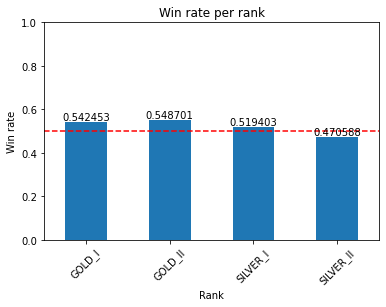

In [51]:
# Calculate average win rate per rank
df_win_rank = df_prota.groupby("rank")["win"].mean().reset_index()

# Plot the graph
ax = df_win_rank.plot(x="rank",
                      y="win",
                      kind="bar",
                      title="Win rate per rank",
                      ylim=[0, 1],
                      legend=False,
                      xlabel="Rank",
                      ylabel="Win rate")
# Add values to bar for better visibility
ax.bar_label(ax.containers[0], label_type="edge")
# Rotate X_axis label 45 degree
plt.xticks(rotation=45)
# Add horizontal line at the 50% winrate
plt.axhline(y=0.5, linestyle="dashed", color="r")
plt.show()

## When do players play?

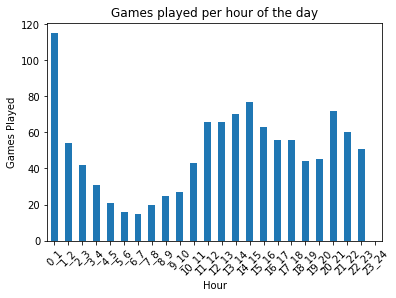

In [56]:
# Games played during each hour of the day

# Retrieve hour of the day from epoch
df_prota["hour"] = pd.to_datetime(df_prota["game_make"], unit = "ms").dt.hour
# Create bins
time_bins = np.arange(0, 25, 1) # 24 hours
# Labels for bins
labels = []
for time in time_bins:
    labels.append(f"{time_bins[time]}_{time_bins[time] + 1}") 
labels = labels[0:-1]
# Bin the data
df_prota["time_bins"] = pd.cut(df_prota["hour"], bins=time_bins, labels=labels, include_lowest=True)

# Calculate how many people play at what hour of the day
df_time_play = df_prota.groupby(["time_bins"]).size().to_frame("size").reset_index()

# Plot the graph
ax = df_time_play.plot(x="time_bins",
                       y="size",
                       kind="bar",
                       title="Games played per hour of the day",
                       legend=False,
                       xlabel="Hour",
                       ylabel="Games Played")
# Rotate X_axis label 45 degree
plt.xticks(rotation=45)
plt.show()

# WHere is the 23-24 bar?
# add time shift to accuratly get this

## Effect of rest

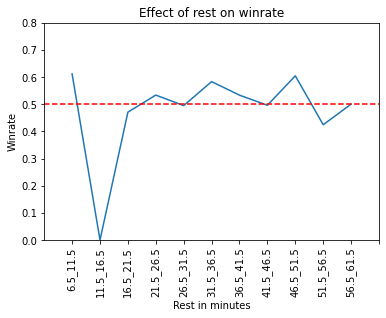

In [57]:
# Rest time vs win rate plot

# Define time bins
min_time = int(df_prota.time_since_last.min())
max_time = int(df_prota.time_since_last.max())
block = 300000 # minutes of rest * 60000 = epoch minutes
rest_bins = np.append(np.arange(min_time, max_time, block), max_time)
# Labels for bins
labels = []
for time in rest_bins:
    time_1 = np.around(time / 60000, decimals=1)
    time_2 = np.around((time + block) / 60000, decimals=1)
    labels.append(f"{time_1}_{time_2}") 
labels = labels[0:-1]
# Bin the data
df_prota["rest_bins"] = pd.cut(df_prota["time_since_last"], rest_bins, labels=labels, include_lowest=True)

# Calculate the mean win rate per bin
df_time_win = df_prota.groupby("rest_bins")["win"].mean().reset_index()

df_time_win
# Plot the graph
# Change the X ticks
levels = len(df_prota["rest_bins"].unique())
x_ticks = np.arange(0, levels + 1, 1)
# TODO: Error bars use yerr = error,
# error = df_prota.groupby("rest_bins")["win"].std()
# Plot
ax = df_time_win.plot(x="rest_bins",
                      y="win",
                      kind="line",
                      title="Effect of rest on winrate",
                      legend=False,
                      xticks=x_ticks,
                      xlim=[-1, 11],
                      ylim=[0, 0.8],
                      xlabel="Rest in minutes",
                      ylabel="Winrate")
# Rotate X_axis label 45 degree
plt.xticks(rotation=90)
# Add horizontal line at the 50% winrate
plt.axhline(y=0.5, linestyle="dashed", color="r")
plt.show()

## Tilted or in the zone?

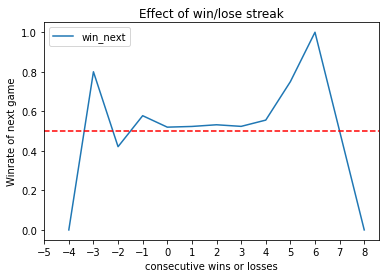

In [58]:
# Win rate during points a win or lose streak
# Calculate the number of games won and lost in succesion per groep of games played within max_rest time of one another 
game_streak = df_prota["streak_id"].diff().ne(0).cumsum()
df_prota["consec_wl"] = df_prota.win.groupby((df_prota.win != df_prota.groupby(game_streak)["win"].shift()).cumsum()).cumcount()
# Turn streak values negative if the game ended in a loss
df_prota.loc[df_prota.loc[:, "win"] == False, "consec_wl":] *= -1
# Add if the next game is a win or lose
df_prota['win_next'] = df_prota.groupby(game_streak)["win"].shift(-1, fill_value=np.nan)
# Calculate mean win rate
df_streak_win = df_prota.groupby(["consec_wl"])["win_next"].mean().reset_index()
# Optional: Calculate mean win rate taking into account their rank. Need to adjut plot then 
# df_streak_win = df_prota.groupby(["rank", "consec_wl"])["win_next"].mean().reset_index()

# Plot the graph
# Change the X ticks
min_num = df_prota["consec_wl"].min()
max_num = df_prota["consec_wl"].max()
x_ticks = np.append(np.arange(min_num, max_num, 1), max_num)
# Plot
ax = df_streak_win.plot(x="consec_wl",
                        y="win_next",
                        kind="line",
                        title="Effect of win/lose streak",
                        legend=True,
                        xticks=x_ticks,
                        # ylim=[0, 1],
                        xlabel="consecutive wins or losses",
                        ylabel="Winrate of next game")
# Add horizontal line at the 50% winrate
plt.axhline(y=0.5, linestyle="dashed", color="r")
plt.show()


# show distribution of datapoints of the win streaks
df_prota['consec_wl'].value_counts()
# and add eroor bars

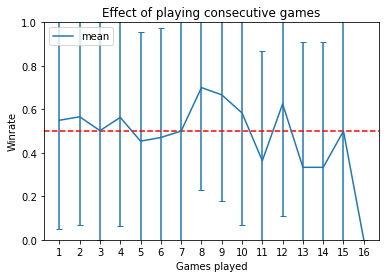

In [60]:
# TODO: apply this method of error bars and graphs to all others if required
# Win rates based on played games in a streak
# Calculate the average win rate of each players first second third etc. game
df_prota["game_nr"] = df_prota.groupby("streak_id")["puuid"].rank(method="first", ascending=True)
df_win_game = df_prota.groupby(["game_nr"])["win"].agg([np.mean, np.std]).reset_index()

# Plot the graph
# Change the X ticks
max_num = df_win_game["game_nr"].max()
x_ticks = np.arange(1, max_num + 1, 1)
# Plot
ax = df_win_game.plot(x="game_nr",
                      y="mean",
                      kind="line",
                      title="Effect of playing consecutive games",
                      legend=True,
                      xticks=x_ticks,
                      ylim=[0, 1],
                      xlabel="Games played",
                      ylabel="Winrate",
                      yerr="std",
                      capsize=3)

# Add horizontal line at the 50% winrate
plt.axhline(y=0.5, linestyle="dashed", color="r")
plt.show()


# Win prediction

## Machine learning aproaches

In [66]:
# Preprocessing
# Drop remake rows:
df = df_prota.drop(df_prota[df_prota.game_remake == True].index).dropna()

# drop useless columns:
bad_cols = ["reg", "match_id", "puuid", "rank", "pos", "game_remake", "game_pre_15_surr"]
df.drop(bad_cols, axis = 1, inplace=True)
df


,alive_max,assist,assist_first_kill,assist_first_tower,assist_inhib,assist_turret,baron_kill,buy_control_ward,buy_item,buys_consum,...,vision_score,win,time_since_last,streak_id,rest_bins,hour,time_bins,consec_wl,win_next,game_nr
11335,364,10,False,True,1,5,0,0,17,0,...,10,True,2187532.0,0,31.5_36.5,21,20_21,1,False,2.0
11305,349,4,False,False,0,0,0,0,14,2,...,9,False,1870674.0,1,26.5_31.5,21,20_21,-1,True,2.0
11275,615,2,False,True,0,1,0,0,11,2,...,5,True,1776718.0,2,26.5_31.5,0,0_1,0,True,2.0
11240,1097,9,False,False,2,5,0,0,23,2,...,12,True,650364.0,3,6.5_11.5,17,16_17,0,True,2.0
11210,452,3,False,False,0,0,0,1,14,1,...,6,False,1749328.0,4,26.5_31.5,21,20_21,-1,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,334,6,False,False,0,2,0,0,25,2,...,11,False,2114818.0,247,31.5_36.5,13,12_13,0,False,2.0
88,1338,5,False,False,0,2,0,2,29,6,...,23,False,1274747.0,248,16.5_21.5,19,18_19,0,False,2.0
58,581,8,False,False,2,4,0,1,30,5,...,18,True,2274512.0,249,36.5_41.5,18,17_18,1,False,2.0
43,511,7,False,False,0,0,0,1,22,2,...,15,False,2302076.0,249,36.5_41.5,19,18_19,0,False,3.0


In [67]:
# Split the data into a training and test set
X = df.drop("win", axis=1)
y = df["win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


ordered_rank_features = SelectKBest(score_func=f_classif, k="all")
ordered_features = ordered_rank_features.fit(X_train, y_train)


ValueError: Cannot cast object dtype to float64

In [ ]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=100),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "Support Vector Machine (RBF Kernel)": SVC(),
    "Decission Tree": DecisionTreeClassifier(),
    "Adaboost": AdaBoostClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

for name, model in models.items():
  model.fit(X_train, y_train)
  print(f" {name} trained")

 Logistic Regression trained
 Support Vector Machine (Linear Kernel) trained
 Support Vector Machine (RBF Kernel) trained
 Decission Tree trained


c:\Users\Ryan\miniconda3\envs\tilt\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Adaboost trained
 Random Forest trained
 Gradient Boosting Classifier trained


In [ ]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

scores_list = []
for name,model in models.items():
  scores_list.append(
        {
            "Model": name,
            "Accuracy": accuracy_score(y_test, model.predict(X_test)),
            "Precision": precision_score(y_test, model.predict(X_test)),
            "Recall": recall_score(y_test, model.predict(X_test)),
            "F1-Score": f1_score(y_test, model.predict(X_test))
        }
    )

scores = pd.DataFrame(scores_list)
scores

c:\Users\Ryan\miniconda3\envs\tilt\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.509934,0.509934,1.000000,0.675439
1,Support Vector Machine (Linear Kernel),0.490066,0.000000,0.000000,0.000000
2,Support Vector Machine (RBF Kernel),0.509934,0.509934,1.000000,0.675439
3,Decission Tree,0.695364,0.696203,0.714286,0.705128
4,Adaboost,0.721854,0.705882,0.779221,0.740741
5,Random Forest,0.754967,0.727273,0.831169,0.775758
6,Gradient Boosting Classifier,0.741722,0.706522,0.844156,0.769231


## Dimension reduction


<AxesSubplot:>

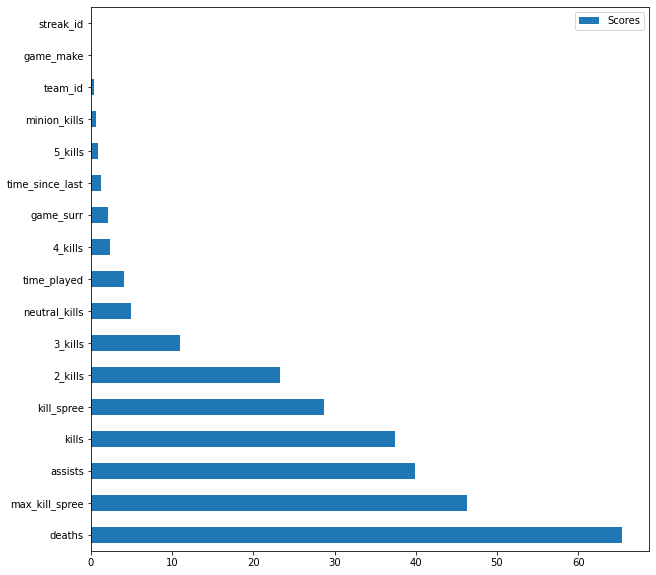

In [ ]:
# TODO: figure out what ANOVA-F is
ordered_rank_features = SelectKBest(score_func=f_classif, k="all")
ordered_features = ordered_rank_features.fit(X_train, y_train)
features = pd.DataFrame(ordered_features.scores_, index=X.columns,
columns=["Scores"]).sort_values(by="Scores", ascending=False)
features.plot(kind='barh', figsize=(10,10))

In [ ]:
# Future plans:
# define good and bad stats using medians/average normal dist? 
# Win rate in next game after losing with bad stats
# Win rate in next game after losing with good stats
# Win rate in next game after winning with bad stats
# Win rate in next game after winning with good stats


# Some information about tilt
definition of tilt in league of legends and what causes it : https://dl.acm.org/doi/pdf/10.1145/3411764.3445143
or https://www.diva-portal.org/smash/record.jsf?pid=diva2%3A1591520&dswid=8002



In [1]:
# search player
# list of players
#     van spelers zoek games
#     zoek op game
#     results from all players
#     filter on players used to start seach and store that 

In [ ]:
len(sumo_info.columns)

24

Tests


In [11]:
# GEathering data
puuid = "qZHgkSP20VlVqICoXMoFpVDfFk8NV54naBnTqgPEZN6GYVdn-Zjo_dVKWYX0gNVXNscT2EtrVnAieQ"
game_ids = ["EUW1_5414939600","EUW1_5414956170","EUW1_5414912862","EUW1_5373474765","EUW1_5373418712","EUW1_5373451710","EUW1_5373326619","EUW1_5373235566","EUW1_5373148726","EUW1_5373075843","EUW1_5342677497","EUW1_5342672741","EUW1_5342645103","EUW1_5342510081","EUW1_5342462317"]

test_data = geather_data(puuid, game_ids)
# print(test.columns)

test_data
# test["puuid"]

NameError: name 'lol_watcher' is not defined

In [ ]:

puuid = "qZHgkSP20VlVqICoXMoFpVDfFk8NV54naBnTqgPEZN6GYVdn-Zjo_dVKWYX0gNVXNscT2EtrVnAieQ"
game_ids = ["EUW1_5414939600", "EUW1_5373474765", "EUW1_5373418712", "EUW1_5373451710", "EUW1_5342672741"]


test, test2 = filt_matches(geather_data(puuid, game_ids),
                    max_rest=settings["max_rest"],
                    min_streak=3)
# print(beta.to_string())

In [16]:
streak1 = pd.read_csv(data_dir / "summoner_data_streak_raw_iron.tsv", sep = "\t")
streak2 = pd.read_csv(data_dir / "summoner_data_streak_raw_bronze_plat.tsv", sep = "\t")
streak3 = pd.read_csv(data_dir / "summoner_data_streak_raw_silverrest.tsv", sep = "\t")
nostreak1 = pd.read_csv(data_dir / "summoner_data_nostreak_raw_iron.tsv", sep = "\t")
nostreak2 = pd.read_csv(data_dir / "summoner_data_nostreak_raw_bronze_plat.tsv", sep = "\t")
nostreak3 = pd.read_csv(data_dir / "summoner_data_nostreak_raw_silverrest.tsv", sep = "\t")

streak = streak1.append(streak2)
streak = streak.append(streak3)
nostreak = nostreak1.append(nostreak2)
nostreak = nostreak.append(nostreak3)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_6376\810309694.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  streak = streak1.append(streak2)
C:\Users\Ryan\AppData\Local\Temp\ipykernel_6376\810309694.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  streak = streak.append(streak3)
C:\Users\Ryan\AppData\Local\Temp\ipykernel_6376\810309694.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nostreak = nostreak1.append(nostreak2)
C:\Users\Ryan\AppData\Local\Temp\ipykernel_6376\810309694.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nostreak = nostreak.append(nostreak3)


In [17]:
# Store streak data in a tsv file
streak_loc = data_dir / "summoner_data_streak_raw.tsv"
nostreak_loc = data_dir / "summoner_data_nostreak_raw.tsv"

streak.to_csv(streak_loc,
            sep="\t",
            index=False)

nostreak.to_csv(nostreak_loc,
            sep="\t",
            index=False)


In [19]:
streak.head(100)

,reg,match_id,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,championTransform,...,gameCreation,gameStartTimestamp,game_end,game_end_prev,game_make_next,time_since_last,time_till_next,rank,idx,streak_id
0,euw1,EUW1_5390745766,3,0,0,16629,17,23,Tryndamere,0,...,1627585963000,1627586210242,1627586211943,1.627584e+12,1.629553e+12,1667090.0,1.966353e+09,IRON_I,40,9
1,euw1,EUW1_5390745766,7,0,0,10731,13,121,Khazix,0,...,1627585963000,1627586210242,1627586211943,1.627584e+12,1.629553e+12,1667090.0,1.966353e+09,IRON_I,41,9
2,euw1,EUW1_5390745766,4,0,0,10994,13,101,Xerath,0,...,1627585963000,1627586210242,1627586211943,1.627584e+12,1.629553e+12,1667090.0,1.966353e+09,IRON_I,42,9
3,euw1,EUW1_5390745766,11,0,0,12078,14,110,Varus,0,...,1627585963000,1627586210242,1627586211943,1.627584e+12,1.629553e+12,1667090.0,1.966353e+09,IRON_I,43,9
4,euw1,EUW1_5390745766,9,0,0,10401,13,22,Ashe,0,...,1627585963000,1627586210242,1627586211943,1.627584e+12,1.629553e+12,1667090.0,1.966353e+09,IRON_I,44,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,euw1,EUW1_5388729359,11,0,0,12059,14,64,LeeSin,0,...,1627486686000,1627486848900,1627486850499,1.627429e+12,1.627489e+12,57275878.0,1.874501e+06,IRON_I,145,15
96,euw1,EUW1_5388729359,3,1,15,16571,17,107,Rengar,0,...,1627486686000,1627486848900,1627486850499,1.627429e+12,1.627489e+12,57275878.0,1.874501e+06,IRON_I,146,15
97,euw1,EUW1_5388729359,8,0,12,16034,16,101,Xerath,0,...,1627486686000,1627486848900,1627486850499,1.627429e+12,1.627489e+12,57275878.0,1.874501e+06,IRON_I,147,15
98,euw1,EUW1_5388729359,12,0,2,12986,14,81,Ezreal,0,...,1627486686000,1627486848900,1627486850499,1.627429e+12,1.627489e+12,57275878.0,1.874501e+06,IRON_I,148,15
